# Solar-System Problem :   WorkPrecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  
    
<li><a href="#Definition-of-the-N-body-problem"> 
              Definition of the N-body problem</a></li>  

<li><a href="#Initial-value-problem:-Solar-System">
             Initial value problem: Solar-System</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams-(Float64)">
             Work-Precision diagrams (Float64)</a></li> 
             
<li><a href="#Save/Load-Data">
            Save/Load Data</a></li>  

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using RecursiveArrayTools
using IRKGaussLegendre 

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

8

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem



**Equations**


The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:

\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}

This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm).
\end{equation*}


**State variables and parameters**

We implement the state variables as an array with three indices:

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{3\times N \times 2}, 
\end{equation*}

where $u[i,j,k] \in \mathbb{R}$:

- The index $i$ takes the values $y=1,2,3$, referring to the coordinate $x,y,z$ respectively.
- The index $j$ takes the values $j=1,2,\dots,N$, referring to the corresponding planet.
- The index $k$ takes the values $k=1,2$, referring to the position if $k=1$ and the speed if $k=2$.

The vector with the constant parameters of the problem is::

\begin{equation*}
p = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N,
\end{equation*}

where $Gm_i$ corresponds to the mass of the $i$th body multiplied by the universal gravity constant $G$.

### Initial value problem: 9-body model of the Solar System

We consider $N=9$ bodies of solar system: the Sun, Mercury, Venus, Earth-Moon, Mars, Jupiter, Saturn, Uranus, Neptune,  Pluto.
The initial values $u_0$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969).

<a href="#top">Back to the top</a>

## Initial value problem: Solar-System

In [4]:
setprecision(BigFloat, 108);
include("../ODEProblems/Nbody.jl")
include("../ODEProblems/NbodyDyn.jl")
include("../ODEProblems/Nbody2nd.jl")
include("../ODEProblems/Initial9Body.jl")

dt=6
t0=0.0
t1=10^4

u064,Gm64 =Initial9Body(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=Initial9Body(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128)

q064=u064[:,:,1]
v064=u064[:,:,2]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[:,:,1]
v0128=u0128[:,:,2]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);


(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64, 3}, Vector{Float64}, Tuple{Float64, Int64}, Array{BigFloat, 3}, Vector{BigFloat}, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [5]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32, maxiters=10^9);
#@save "./Data/Solar_System_solT1000.jld2" sol


@load "./Data/Solar_System_solT1000.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256,Gm256=Initial9Body(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0-1))

(10000.0f0, -2.2450548f-33)

In [6]:
ux=sol.u[end]
solx=ArrayPartition(ux[:,:,1], ux[:,:,2])
test_soldyn = TestSolution(t1,[solx]);

ux=sol.u[end]
solx2nd=ArrayPartition(ux[:,:,2],ux[:,:,1])
test_solx2nd = TestSolution(t1,[solx2nd]);

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [7]:
abstols = 1.0 ./ 10.0 .^ (10:15)
reltols = 1.0 ./ 10.0 .^ (10:15)

dts=16*0.866.^(0:length(reltols)-1);

### Second Order Problem: Vern9, IRKGL16,  DPRKN12

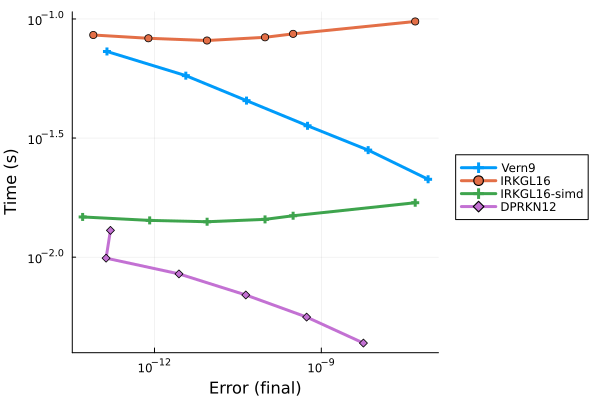

In [10]:
setups = [
          Dict(:alg=>Vern9())
]
solnames = ["Vern9"]
wp1 = WorkPrecisionSet(probdyn64,abstols,reltols,setups;appxsol=test_soldyn, save_everystep=false,numruns=10,maxiters=10^9, names=solnames);
plot(wp1);

#########################################################

setups = [
          Dict(:alg=>IRKGL16(second_order_ode=true,simd=false),:adaptive=>true)
          Dict(:alg=>IRKGL16(second_order_ode=true,simd=true),:adaptive=>true)

]
solnames = ["IRKGL16", "IRKGL16-simd" ]
wp2 = WorkPrecisionSet(prob64,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=10,maxiters=10^9, names=solnames);
plot!(wp2);

#########################################################

setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp3 = WorkPrecisionSet(prob2nd64,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=10,maxiters=10^9,name=solnames)
plot!(wp3)

<a href="#top">Back to the top</a>